In [2]:
!pip install GPy

     |████████████████████████████████| 1.0MB 2.8MB/s 
     |████████████████████████████████| 71kB 7.6MB/s 
  Created wheel for GPy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2633931 sha256=5846870b9c278e5c4ed5babfd22c9a2cc473f2bb99c29d1bc15fda16074c192e
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102551 sha256=c71fc280753e3537dd1fb9ebc0a70f91895e96df5210934c2a9839dc5ddb7b06
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy paramz


In [3]:
import GPy as GPy
import numpy as np
import pylab as pb
import pymc3 as pm
%matplotlib inline

# Polynomial regression

Consider again polynomial regression

$$
\phi(x) = (1, x, x^2) 
$$

and, therefore,

$$
\begin{aligned}
f(x)&=w_0+w_1 x+w_2 x^2
\end{aligned}
$$

This is our polynomial regression function with unknown parameters 
$w_i$.


It is straightforward to write down the probabilistic model for polynomial regression:

Ingredient 1:

$$
y=\sum\limits_{i=0}^{2} {\color{blue} w_i}x^i,
$$

Ingredient 2: prior hypothesis space, we place a prior on the weights

$$
p(w_{i})=N(w_{i},0,\alpha_i)
$$

where $\alpha_i$ is the standard deviation (e.g., $\alpha_i=10$)

Ingredient 3: the likelihood (assuming Gaussian noise)

$$
\begin{aligned}
p(\text{data}|h)&=\prod_{i=1}^n N\left(y_i;\sum\limits_{i=0}^{2} {\color{blue} w_i}x^i,\sigma\right)
\end{aligned}
$$

Let us generate some data and write down the PyMC3 model that solves this regression problem.



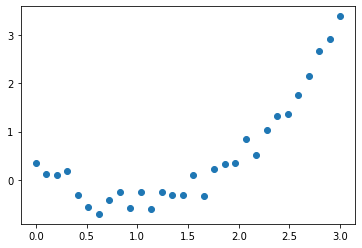

In [ ]:
#generate some data
x=np.linspace(0,3,30)
y=0.5-2*x+x**2+np.random.randn(len(x))*0.2
pb.scatter(x,y)
xv=x[:,None]
X=np.hstack([xv**0,xv**1,xv**2])

In parametric nonlienar (polynomial) regression, we place a prior on the parameters $\alpha,\beta$ and compute their posterior

In [ ]:
import theano.tensor as tt

mymodel=pm.Model()
with mymodel:
    beta  = pm.Normal('w', 0.0,10, shape=(3,))
    sigma = pm.Uniform('sigma',0.0001,30)
    mu=pm.math.dot(X,beta)
    l1=pm.Normal('Like',mu, sigma, observed=y)

with mymodel:
    posterior_samples=pm.sample(5000,tune=2000,chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, w]
Sampling chain 0, 72 divergences: 100%|██████████| 7000/7000 [00:12<00:00, 539.27it/s]
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6107463192640802, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


We use then the posterior to compute the *regression function* and make predictions (considering also the uncertainty)

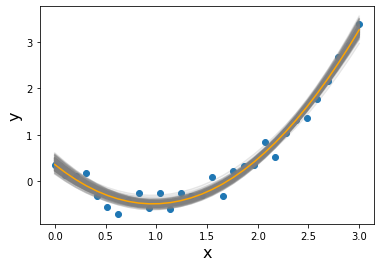

In [ ]:
for i in range(200):
    pb.plot(x,np.dot(X,posterior_samples['w'][i]),c='gray',alpha=0.2)#regression line
pb.plot(x,np.dot(X,posterior_samples['w'].mean(axis=0)),c='orange')
pb.scatter(x,y)
pb.xlabel("x",fontsize=16)
pb.ylabel("y",fontsize=16);

## Rethinking linear regression 
Let's try to rethink nonlinear (functional) regression.

In nonlinear regression we want to find a functional model that relates $x$ to $y$

$$
y = f(x)
$$

In linear regression we assume that the model is linear

$$
y = \alpha + \beta\, x
$$

with $\alpha \sim N(0,\sigma_{\alpha})$ and $\beta \sim N(0,\sigma_{\beta})$. 

From these assumptions, it follows that, for a fixed $x$, 

$$
E[f(x)]= E[\alpha + \beta\, x]=E[\alpha] + E[\beta]\, x = 0 ~~~\forall\,x
$$

where $E$ means the expected value, and for fixed $x_1,x_2$:

$$
\begin{aligned}
E[f(x_1)f(x_2)]&= E[(\alpha + \beta\, x_1)(\alpha + \beta\, x_1)]
&=E[\alpha^2] +E[\alpha \beta]x_1+E[\alpha \beta]x_2 + E[\beta^2]x_1x_2 = \sigma^2_{\alpha}+\sigma^2_{\beta}x_1x_2
\end{aligned}
$$

The above formulas give us mean and variance of $f$. It is possible to  show that the function $f$ is a-priori multivariate Normal distributed with zero mean and covariance matrix calculated as follows (it inherits the gaussianity by  $\alpha,\beta$). We first define the function of two arguments

$$
K(x_1,x_2)=[1,x_1,x_1^2]\begin{bmatrix}
                 \alpha_0 & 0 &0\\
                 0 & \alpha_1 & 0\\
                 0 & 0 & \alpha_2
                \end{bmatrix}
                \begin{bmatrix}
                 1\\
                 x_2\\
                 x_2^2
                \end{bmatrix}
$$

 which is called **Kernel function** and evaluate it for each pair of $x$ points in our training dataset, obtaining the covariance matrix

 $$
K(X,X):=\begin{bmatrix}
        k(x_1,x_1) & k(x_1,x_2) & \dots & k(x_1,x_n)\\
        k(x_2,x_1) & k(x_2,x_2)& \dots & k(x_2,x_n)\\
        \vdots & \vdots & \vdots  & \vdots \\
        k(x_n,x_1) & k(x_n,x_2)& \dots & k(x_n,x_n)\\
        \end{bmatrix}
$$

let's do it with Python.

In [ ]:
def K(x_1,x_2,alpha, deg): #when degree=1 we get a linear kernel
    xx1 = x_1**np.arange(0,deg+1)
    xx2 = x_2**np.arange(0,deg+1)
    return np.linalg.multi_dot([xx1,np.diag(alpha),xx2.T])

alpha=np.array([1,1,1])*1
M=K(x[:,None],x[:,None], alpha**2, deg=2)#covariance matrix
M.shape

(80, 80)

We can generate our prior hypothesis space as follows:

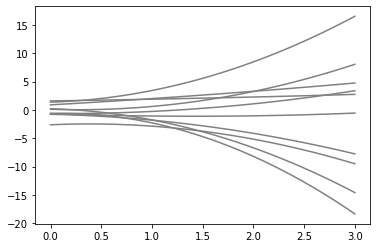

In [ ]:
pb.plot(x,pm.MvNormal.dist(np.zeros(len(x),float),cov=M).random(size=10).T,color='gray');

These are prior polynomial function generated by the prior on $f$. They are second degree polynomial functions. The above way of sampling is  equivalent to the following way of sampling (we already know):

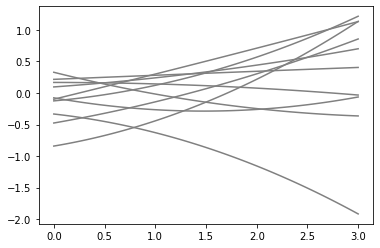

In [ ]:
alpha=pm.Normal.dist(0,sd=alpha[0]).random(size=10).T
beta1=pm.Normal.dist(0,sd=alpha[1]).random(size=10).T
beta2=pm.Normal.dist(0,sd=alpha[2]).random(size=10).T
for i in range(10):
    pb.plot(x,alpha[i]+beta1[i]*x+beta2[i]*x**2,color='gray');

Since these two models are equivalent, we can then compute the posterior using this equivalent model

In [ ]:
import theano.tensor as tt
from pymc3.gp.util import cholesky

mymodel=pm.Model()
with mymodel:
    # Multivariate Gaussian prior on f
    fr  = pm.MvNormal('fr', np.zeros(len(x)),np.eye(M.shape[0]), shape=(len(x),))
    f = pm.Deterministic('f', cholesky(M+np.eye(M.shape[0])*1e-6).dot(fr))
    #likelihood
    sigma = pm.HalfCauchy('sigma',2)
    l1=pm.Normal('Like',f, sigma, observed=y)
    
with mymodel:
    posterior=pm.sample(3000,chains=1)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, fr]
Sampling chain 0, 1 divergences: 100%|██████████| 3500/3500 [00:36<00:00, 95.21it/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Note that the instructions 

`  
    fr  = pm.MvNormal('fr', np.zeros(len(x)),np.eye(M.shape[0]), shape=(len(x),))
    f = pm.Deterministic('f', cholesky(M+np.eye(M.shape[0])*1e-6).dot(fr))`

are equivalent to 

`  
    f  = pm.MvNormal('f', np.zeros(len(x)),M+np.eye(M.shape[0])*1e-6, shape=(len(x),))`
    
but the former one is more numerically stable. We have added `np.eye(M.shape[0])*1e-6` again for numerical stability.

In this case, we already obtain samples of the regression function $f$ computed at the training points, similar to what we were used to do with `mu=pm.Deterministic("mu", alpha+beta1*x+beta2*x**2)`.

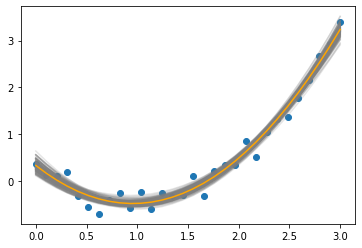

In [ ]:

pb.scatter(x,y)
for i in range(200):
    pb.plot(x,posterior['f'][i],c='gray',alpha=0.2)#regression line
pb.plot(x,np.mean(posterior['f'],axis=0),color='orange')

## RBF covariance matrix

So if the two previous models are equivalent, what is the advantage of the placing a prior directly on $f$. The advantage is that by changing the Kernel (covariance matrix) we can obtain more powerful models then simply polynomial regression.

We can for instance consider the same probabilistic model but change the way we generate the covariance matrix 

In [ ]:
#square exponential Kernel
def K(x_1,x_2, lengthscale=1.0, sigma_f=1.0):
    sqdist = np.sum(x_1**2/lengthscale**2, 1).reshape(-1, 1) + np.sum(x_2**2/lengthscale**2, 1) - 2 * np.dot(x_1/lengthscale**2, x_2.T)
    return sigma_f**2 * np.exp(-0.5 * sqdist)



This is called **Square Exponential Kernel** function, it has two positive parameters, the lengthscale and the scale $\sigma_f$. It can be used to place a prior on smooth functions, by changing `lengthscale` we can have different degrees of smoothness (less smooth for small lengthscale).

In [ ]:
M=K(x[:,None],x[:,None])
M.shape

(80, 80)

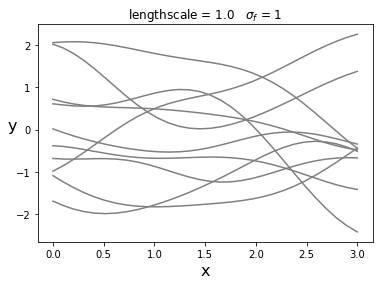

In [ ]:
lengthscale=np.ones(1)*1
sigma_f=1

M=K(x[:,None],x[:,None],lengthscale=lengthscale,sigma_f=sigma_f)
pb.plot(x,pm.MvNormal.dist(np.zeros(len(x),float),cov=M).random(size=10).T,color='gray');
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.title("lengthscale = "+str(lengthscale[0]) + "   " + "$\\sigma_f$ = "+str(sigma_f) );

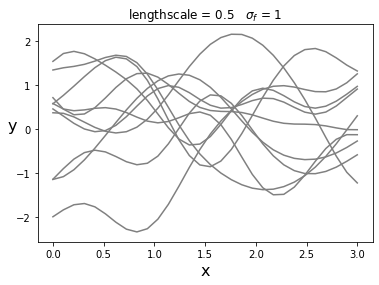

In [ ]:
lengthscale=np.ones(1)*0.5
sigma_f=1

M=K(x[:,None],x[:,None],lengthscale=lengthscale,sigma_f=sigma_f)
pb.plot(x,pm.MvNormal.dist(np.zeros(len(x),float),cov=M).random(size=10).T,color='gray');
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.title("lengthscale = "+str(lengthscale[0]) + "   " + "$\\sigma_f$ = "+str(sigma_f) );

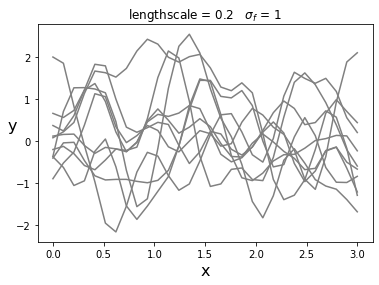

In [ ]:
lengthscale=np.ones(1)*0.2
sigma_f=1

M=K(x[:,None],x[:,None],lengthscale=lengthscale,sigma_f=sigma_f)
pb.plot(x,pm.MvNormal.dist(np.zeros(len(x),float),cov=M).random(size=10).T,color='gray');
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.title("lengthscale = "+str(lengthscale[0]) + "   " + "$\\sigma_f$ = "+str(sigma_f) );

Let's apply it to estimate the posterior of our previous regression problem

In [ ]:
M=K(x[:,None],x[:,None])
    
mymodel=pm.Model()
with mymodel:
    # Multivariate Gaussian prior on f
    fr  = pm.MvNormal('fr', np.zeros(len(x)),np.eye(M.shape[0]), shape=(len(x),))
    f = pm.Deterministic('f', cholesky(M+np.eye(M.shape[0])*1e-6).dot(fr))
    #likelihood
    sigma = pm.HalfCauchy('sigma',2)
    l1=pm.Normal('Like',f, sigma, observed=y)
    
with mymodel:
    posterior=pm.sample(3000,chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, fr]
Sampling chain 0, 1 divergences: 100%|██████████| 3500/3500 [00:32<00:00, 106.22it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


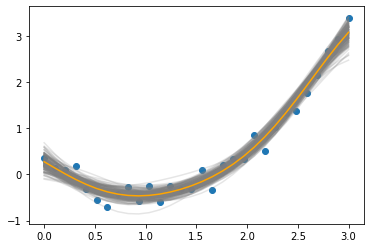

In [ ]:

pb.scatter(x,y)
for i in range(200):
    pb.plot(x,posterior['f'][i],c='gray',alpha=0.2)#regression line
pb.plot(x,np.mean(posterior['f'],axis=0),color='orange')

The previous model that uses a RBF kernel to generate the covariance matrix, it is 
* an universal approximator of nonlinear functions
* it corresponds to a single layer Neural Network with **infinite** hidden units 

In practice, it is more powerful then any single layer NN you can write in Keras and it is **probabilistic** so it returns a measure of uncertainty.

To see data, let's generate data from a nonlinear function

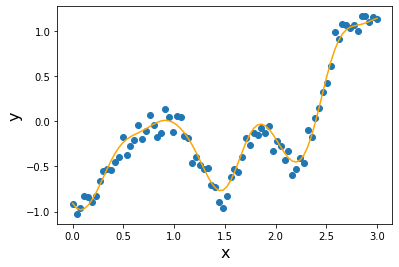

In [ ]:
np.random.seed(460)
lengthscale=np.ones(1)*0.3
sigma_f=1
x=np.linspace(0,3,80)
M=K(x[:,None],x[:,None],lengthscale=lengthscale,sigma_f=sigma_f)
f=pm.MvNormal.dist(np.zeros(len(x),float),cov=M).random(size=1)

y=f+np.random.randn(len(x))*0.1
pb.plot(x,f,c='orange')
pb.scatter(x,y)
pb.xlabel("x",fontsize=16)
pb.ylabel("y",fontsize=16);

Now we estimate the nonlinear function by placing a prior directly on $f$.

In [ ]:
M=K(x[:,None],x[:,None])
    
mymodel=pm.Model()
with mymodel:
    # Multivariate Gaussian prior on f
    fr  = pm.MvNormal('fr', np.zeros(len(x)),np.eye(M.shape[0]), shape=(len(x),))
    f = pm.Deterministic('f', cholesky(M+np.eye(M.shape[0])*1e-6).dot(fr))
    #likelihood
    sigma = pm.Uniform('sigma',0.001,0.3)
    l1=pm.Normal('Like',f, sigma, observed=y)
    
with mymodel:
    posterior=pm.sample(3000,tune=2000,chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, fr]
Sampling chain 0, 0 divergences: 100%|██████████| 5000/5000 [01:00<00:00, 83.29it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


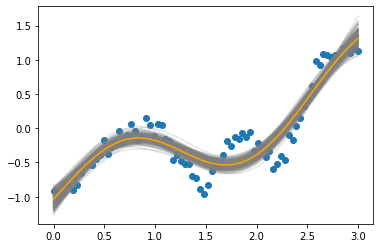

In [ ]:
pb.scatter(x,y)
for i in range(200):
    pb.plot(x,posterior['f'][i],c='gray',alpha=0.2)#regression line
pb.plot(x,np.mean(posterior['f'],axis=0),color='orange')

### Analytical Posterior inference
Actually we do not need PyMC3, for regression we can compute the posterior of the previous model in closed form without sampling (with 6 lines of code). Thi avoids

In [ ]:
#it assumes that the Kernel is a RBF kernel
def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    ''' Computes the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s. 
    Args: X_s: New input locations (n x d). 
    X_train: Training locations (m x d). 
    Y_train:  Training targets (m x 1). 
    l: Kernel length parameter. 
    sigma_f: Kernel vertical variation parameter. 
    sigma_y: Noise parameter. 
    Returns: Posterior mean vector (n x d) and covariance matrix (n x n). '''
    K0 = K(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = K(X_train, X_s, l, sigma_f)
    K_ss = K(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = np.linalg.inv(K0)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

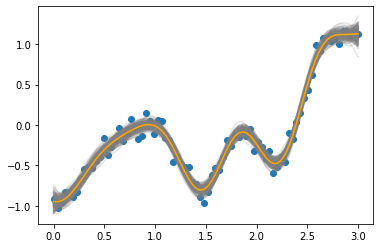

In [ ]:
mu, cov =posterior_predictive(x[:,None], x[:,None], y[:,None], l=lengthscale, sigma_f=sigma_f, sigma_y=0.1)
pb.plot(x,mu,color='orange')
f_samples = np.random.multivariate_normal(mu[:,0], cov, 225)
pb.plot(x,f_samples.T,color='gray',alpha=0.2);
pb.scatter(x,y)
pb.plot(x,mu,color='orange')

## Gaussian Process

The model we have defined by placing a multivariate Normal prior directly on the function $f$
is called **Gaussian Process**.

It is a **nonparametric** model. What does it mean? It means that the number of its parameters grows
with the number of data points. 

You can see that from the definition of the prior

`fr  = pm.MvNormal('fr', np.zeros(len(x)),np.eye(M.shape[0]), shape=(len(x),))
 f = pm.Deterministic('f', cholesky(M+np.eye(M.shape[0])*1e-6).dot(fr))`
 
 Note that the dimension of the sampled $f$ is equal to the length of $x$. So more data we have more
 parameters (the values of $f$ computed at the $x$ in the training points) we include in our model.
 
 This is why GPs are more powerful than NN (thata re parametric models).
 
 PyMC3 implements GP for us, see https://docs.pymc.io/nb_examples/index.html (GP section). 